# STA365 HW3
## Lisa Wang

### Q1
**Question:** 

The *Gibbs sampler* in class for the prior $p(\theta,\tau) \propto 1$ was created by alternatingly sampling from the *full conditional* $p(\theta|\tau,\textbf{x})$ *normal* and  $p(\tau|\theta,\textbf{x})$ *gamma* distributions. Create this *Gibbs sampler* so your code can be used for the sample `x = stats.norm(loc=m, scale=s).rvs(size=n)` for any arbitrary `n`, `m`, and `s`.

*Use the code below or your own code to <u>provide a demonstration of Bayesian inference<u> for this data and model specification.*

**Answer:** 

### Gibbs Sampling:

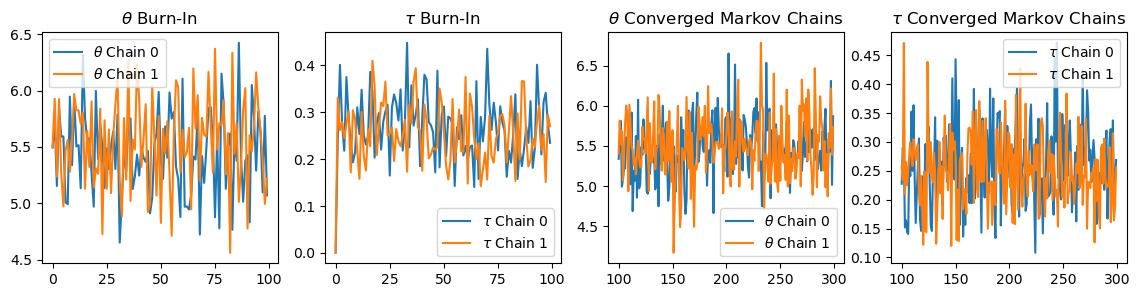

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Function to run Gibbs Sampling for arbitrary n, m, s
def gibbs_sampler(n=30, m=0, s=1, C=2, G=10000):
    x = stats.norm(loc=m, scale=s).rvs(size=n) # Generate x from Normal distribution 
    
    # Chains and iterations
    theta = np.zeros((C, G))
    tau = np.zeros((C, G))

    # Initialization
    theta[:, 0] = np.mean(x)

    for c in range(C):  # Multiple chains
        for g in range(1, G):
            # Sample tau | theta, x (Gamma)
            shape = n / 2 + 1
            scale = 1 / ((np.sum((x - theta[c, g - 1])**2)) / 2)
            tau[c, g] = stats.gamma(a=shape, scale=scale).rvs()

            # Sample theta | tau, x (Normal)
            theta[c, g] = stats.norm(loc=np.mean(x), scale=1 / np.sqrt(tau[c, g] * n)).rvs()

    return theta, tau

# Run the Gibbs sampler
theta_samples, tau_samples = gibbs_sampler(n=30, m=5, s=2, C=2, G=10000)

burn = 100  # Number of burn-in samples
demo = 200  # Number of samples to visualize

fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title(r"$\theta$ Burn-In")
ax[1].set_title(r"$\tau$ Burn-In")
ax[2].set_title(r"$\theta$ Converged Markov Chains")
ax[3].set_title(r"$\tau$ Converged Markov Chains")

for c in range(theta_samples.shape[0]):  # Loop over chains
    ax[0].plot(theta_samples[c, :burn], label=r"$\theta$ Chain " + str(c))
    ax[1].plot(tau_samples[c, :burn], label=r"$\tau$ Chain " + str(c))
    ax[2].plot(np.arange(burn, burn + demo), theta_samples[c, burn:burn + demo], label=r"$\theta$ Chain " + str(c))
    ax[3].plot(np.arange(burn, burn + demo), tau_samples[c, burn:burn + demo], label=r"$\tau$ Chain " + str(c))

ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.show("png")

### Bayesian Inference:

In [40]:
# Extract posterior samples after burn-in
theta_posterior = theta_samples[0, burn:]  # First chain for theta
tau_posterior = tau_samples[0, burn:]  # First chain for tau

# Compute 95% credible intervals
theta_ci = np.quantile(theta_posterior, [0.025, 0.975])
tau_ci = np.quantile(tau_posterior, [0.025, 0.975])

# Print credible intervals
print(f"95% Credible Interval for θ: [{theta_ci[0]:.3f}, {theta_ci[1]:.3f}]")
print(f"95% Credible Interval for σ: [{tau_ci[0]:.3f}, {sigma_ci[1]:.3f}]")

95% Credible Interval for θ: [4.760, 6.224]
95% Credible Interval for σ: [0.144, 2.638]


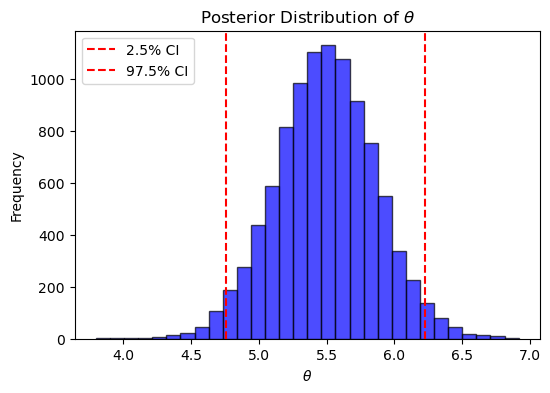

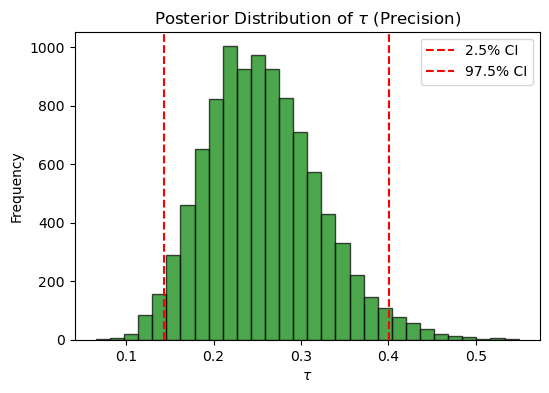

In [105]:
# Plot posterior distribution of theta
plt.figure(figsize=(6,4))
plt.hist(theta_posterior, bins=30, alpha=0.7, color="blue", edgecolor="black")
plt.axvline(theta_ci[0], color="red", linestyle="--", label="2.5% CI")
plt.axvline(theta_ci[1], color="red", linestyle="--", label="97.5% CI")
plt.xlabel(r"$\theta$")
plt.ylabel("Frequency")
plt.title(r"Posterior Distribution of $\theta$")
plt.legend()
plt.show()

# Plot posterior distribution of tau
plt.figure(figsize=(6,4))
plt.hist(tau_posterior, bins=30, alpha=0.7, color="green", edgecolor="black")
plt.axvline(tau_ci[0], color="red", linestyle="--", label="2.5% CI")
plt.axvline(tau_ci[1], color="red", linestyle="--", label="97.5% CI")
plt.xlabel(r"$\tau$")
plt.ylabel("Frequency")
plt.title(r"Posterior Distribution of $\tau$ (Precision)")
plt.legend()
plt.show("png")

### Q2
**Question:** 

**Part 1:**

Derive the *full conditional distributions* $p(\tau|\theta, \mathbf{x})$ and $p(\theta|\tau, \mathbf{x})$ if $p(\theta)$ is $N(\theta_0, \tau^2_0)$ and $p(\tau) \propto \tau^{\frac{\alpha}{2}-1} e^{- \frac{\lambda}{2} \tau}$. 

*Explain how to equate $\alpha$ and $\lambda$ with controlling the amount and nature of information the prior contributes to the posterior. How can we interpret these as controlling a "number of data points" contributed by the prior relative to the number of data points contributed to the posterior through the likelihoood?*

**Part 2:**

Create an updated version of the *Gibbs sampler* for $N(\theta_0, \tau^2_0)$ and $\textrm{gamma}(\textrm{shape}=\frac{\alpha}{2}, \textrm{rate}=\frac{\lambda}{2})$ priors for $p(\theta)$ and $p(\tau)$ respectively. 

*Demonstrate how changing the prior hyperparameters influences the posterior relative to the sample and the likelihood.*

**Answer:** 

**Part 1:**

### **Derivation of $p(\tau | \theta, x)$**

By Bayes' Theorem:

$$
p(\tau | \theta, x) \propto p(x | \theta, \tau) p(\tau)
$$

With $x_i \sim N(\theta, \tau^{-1})$, the likelihood function is:

$$
\begin{align}
p(x | \theta, \tau) &= \prod_{i=1}^{n} \frac{\sqrt{\tau}}{\sqrt{2\pi}} \exp\left( -\frac{\tau}{2} (x_i - \theta)^2 \right) \\
&\propto \tau^{n/2} \exp\left( -\frac{\tau}{2} \sum_{i=1}^{n} (x_i - \theta)^2 \right)
\end{align}
$$

Multiplying likelihood and prior:

$$
\begin{align}
p(\tau | \theta, x) &\propto \tau^{n/2} \exp\left( -\frac{\tau}{2} \sum_{i=1}^{n} (x_i - \theta)^2 \right) \cdot \tau^{\frac{\alpha}{2} - 1} \exp\left(-\frac{\lambda}{2} \tau \right) \\
&\propto \tau^{\frac{n+\alpha}{2} - 1} \exp\left( -\frac{\tau}{2} \left[ \sum_{i=1}^{n} (x_i - \theta)^2 + \lambda \right] \right)
\end{align}
$$

This is the kernel of a Gamma distribution.

**Our Posterior Distribution:**

$$
\tau | \theta, x \sim \text{Gamma} \left( \frac{n+\alpha}{2}, \frac{\lambda + \sum_{i=1}^{n} (x_i - \theta)^2}{2} \right)
$$


### **Derivation of $p(\theta | \tau, x)$**

The prior for $\theta$ is:

$$
p(\theta) \sim N(\theta_0, \tau_0^2)
$$

which implies:

$$
p(\theta) = \frac{1}{\sqrt{2\pi\tau_0^2}} \exp\left( -\frac{(\theta - \theta_0)^2}{2\tau_0^2} \right)
$$


$$
\propto \exp\left( -\frac{1}{2\tau_0^2} (\theta - \theta_0)^2 \right)
$$

Since $x_i \sim N(\theta, \tau^{-1})$, the likelihood is:

$$
\begin{align}
p(x | \theta, \tau) &\propto \exp\left( -\frac{\tau}{2} \sum_{i=1}^{n} (x_i - \theta)^2 \right)
\end{align}
$$

Multiply Likelihood and Prior:

$$
\begin{align}
p(\theta | \tau, x) &\propto p(x | \theta, \tau) p(\theta) \\
&\propto \exp\left( -\frac{\tau}{2} \sum_{i=1}^{n} (x_i - \theta)^2 \right) \cdot \exp\left(-\frac{1}{2\tau_0^2} (\theta - \theta_0)^2 \right)
\end{align}
$$

Expanding the first squared terms:

$$
\begin{align}
p(\theta | \tau, x) &\propto \exp\left( -\frac{1}{2} \left[ \tau n (\theta - \bar{x})^2 \right] \right) \cdot \exp\left( -\frac{1}{2\tau_0^2} (\theta - \theta_0)^2 \right)
\end{align}
$$

$$
= \exp\left( -\frac{1}{2} \left[ \tau n (\theta^2 - 2\theta \bar{x} + \bar{x}^2) + \frac{1}{\tau_0^2} (\theta^2 - 2\theta \theta_0 + \theta_0^2) \right] \right)
$$

$$
= \exp\left( -\frac{1}{2} \left[ \theta^2 (\tau n + \frac{1}{\tau_0^2}) - 2\theta (\tau n \bar{x} + \frac{1}{\tau_0^2} \theta_0) \right] \right)
$$

Complete the Square:

Let:

$$
a = \tau n + \frac{1}{\tau_0^2}, \quad b = \tau n \bar{x} + \frac{1}{\tau_0^2} \theta_0
$$

We rewrite:

$$
a\theta^2 - 2b\theta = a \left( \theta^2 - 2\frac{b}{a} \theta \right)
$$

$$
= a \left( (\theta - \frac{b}{a})^2 - \left(\frac{b}{a}\right)^2 \right)
$$

Thus:

$$
\theta^2 (\tau n + \frac{1}{\tau_0^2}) - 2\theta (\tau n \bar{x} + \frac{1}{\tau_0^2} \theta_0) = (\tau n + \frac{1}{\tau_0^2}) \left( \theta - \frac{\tau n \bar{x} + \frac{1}{\tau_0^2} \theta_0}{\tau n + \frac{1}{\tau_0^2}} \right)^2
$$

**Our Posterior Distribution:**

$$
p(\theta | \tau, x) \sim N \left( \frac{\tau n \bar{x} + \frac{1}{\tau_0^2} \theta_0}{\tau n + \frac{1}{\tau_0^2}}, \frac{1}{\tau n + \frac{1}{\tau_0^2}} \right)
$$

In Bayesian inference, the parameters $\alpha$ and $\lambda$ in the Gamma prior control the influence of prior knowledge relative to observed data. The parameter $\alpha$ determines how much weight the prior contributes compared to the likelihood. Larger $\alpha$ values increase the prior's impact, making the posterior less sensitive to the observed data.

Similarly, $\lambda$ affects the scale of $\tau$, influencing the spread of the posterior. A higher $\lambda$ implies we have a stronger prior, effectively contributing more prior information. This means that the posterior is shaped by both the actual data and the "effective data" from the prior.

When $\alpha$ is large relative to the sample size n, the prior has a greater impact on the posterior estimate; when n≫α, the data dominates, leading to a more data-driven posterior estimate.

**Part 2:**

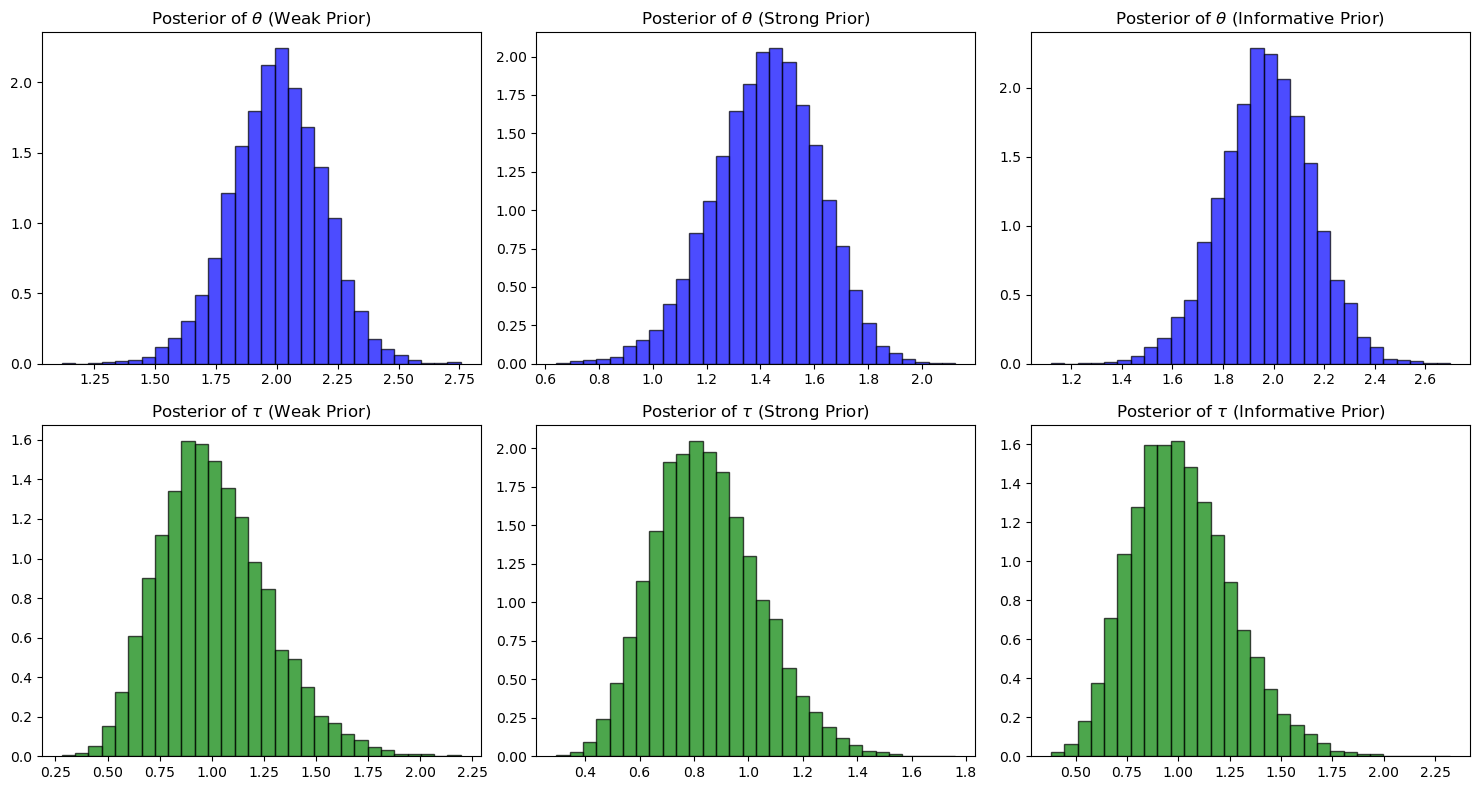

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm

# Sample data
n = 30
x = np.random.normal(loc=2, scale=1, size=n)  # Data generated with mean 2

# Define different prior settings
prior_settings = [
    {"theta_0": np.mean(x), "tau_0_sq": 100, "alpha": 2, "lambda": 2, "label": "Weak Prior"},
    {"theta_0": 0, "tau_0_sq": 0.1, "alpha": 20, "lambda": 20, "label": "Strong Prior"},
    {"theta_0": 1, "tau_0_sq": 1, "alpha": 5, "lambda": 5, "label": "Informative Prior"}
]

num_iter = 10000
burn_in = 1000

fig, ax = plt.subplots(2, len(prior_settings), figsize=(15, 8))

# Run Gibbs sampler for each prior setting
for i, setting in enumerate(prior_settings):
    theta_0, tau_0_sq, alpha, lambda_ = list(setting.values())[:4]
    
    theta_samples = np.zeros(num_iter)
    tau_samples = np.zeros(num_iter)
    
    theta_samples[0] = np.mean(x)
    tau_samples[0] = 1 / np.var(x)

    for j in range(1, num_iter):
        shape_post = (n + alpha) / 2
        scale_post = (lambda_ + np.sum((x - theta_samples[j - 1])**2)) / 2
        tau_samples[j] = gamma.rvs(shape_post, scale=1/scale_post)

        mu_theta = (tau_samples[j] * n * np.mean(x) + (1 / tau_0_sq) * theta_0) / (tau_samples[j] * n + (1 / tau_0_sq))
        sigma_theta_sq = 1 / (tau_samples[j] * n + (1 / tau_0_sq))
        theta_samples[j] = norm.rvs(mu_theta, np.sqrt(sigma_theta_sq))

    theta_samples = theta_samples[burn_in:]
    tau_samples = tau_samples[burn_in:]

    # Plot posteriors
    ax[0, i].hist(theta_samples, bins=30, alpha=0.7, color="blue", edgecolor="black", density=True)
    ax[0, i].set_title(f"Posterior of $\\theta$ ({setting['label']})")
    
    ax[1, i].hist(tau_samples, bins=30, alpha=0.7, color="green", edgecolor="black", density=True)
    ax[1, i].set_title(f"Posterior of $\\tau$ ({setting['label']})")

plt.tight_layout()
plt.show("png")

The prior distributions for both $\theta$ and $\tau$ influence the posterior, as seen in the plots. When a weak prior is used, the posterior distributions for both parameters are more spread out, indicating that the likelihood dominates, and there is higher variability in the estimates. In contrast, with a strong prior, the posterior for $\theta$ is more concentrated around the prior mean, and the posterior for $\tau$ is also more peaked, showing that the prior has contributed more "information" and effectively reduced uncertainty. This happens because the Gamma prior on $\tau$ acts like additional pseudo-data points, reinforcing the prior belief about the precision. The stronger the prior, the more it influences the posterior, reducing variance and pulling estimates toward the prior mean. Meanwhile, an informative prior balances prior knowledge with observed data, resulting in a posterior that reflects both sources of information.

### Q3
**Answer:** 

If the prior is a proper distribution then posterior is proportional to the joint distribution as Bayes Theorem tells us and describe how one might therefore identify the exact distribution of the posterior by just looking at the joint but that finally all this is moot and besides the point because as Bayesians we're going to trade any functional forms of distributions for samples from those distributions to just make histograms and belief (credible interval probability) statements based on those anyway...